Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ custom_row_pooling1d_4          │ (None, 3, 15)          │             0 │
│ (CustomRowPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 3, 64)          │         2,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,299 (28.51 KB)

 Trainable params: 7,299 (28.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/70
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.3185 - loss: 3.4231 - val_accuracy: 0.3000 - val_loss: 2.2269
Epoch 2/70
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6187 - loss: 0.7562 - val_accuracy: 0.7000 - val_loss: 0.7198
Epoch 3/70
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6919 - loss: 0.6808 - val_accuracy: 0.7000 - val_loss: 0.7014
Epoch 4/70
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7026 - loss: 0.7245 - val_accuracy: 0.7000 - val_loss: 0.5853
Epoch 5/70
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7412 - loss: 0.5121 - val_accuracy: 0.8000 - val_loss: 0.4909
Epoch 6/70
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7234 - loss: 0.4689 - val_accuracy: 0.8000 - val_loss: 0.4289
Epoch 7/70
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7873 - loss: 0.3966 - val_accuracy: 0.8000 - val_loss: 0.3924
Epoch 8/70
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8216 - loss: 0.4054 - val_accuracy: 0.8000 - val_loss: 0.3664


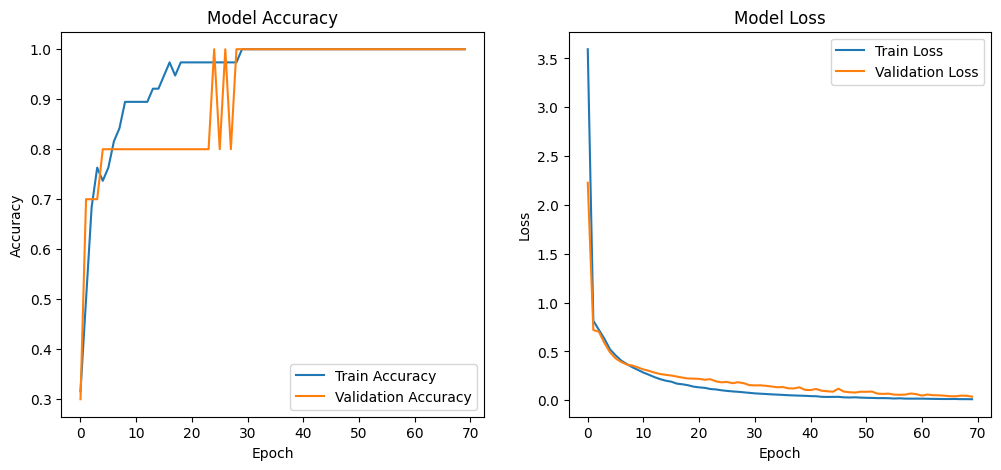

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step

Confusion Matrix:
 [[2 1 1]
 [0 2 0]
 [0 0 6]]


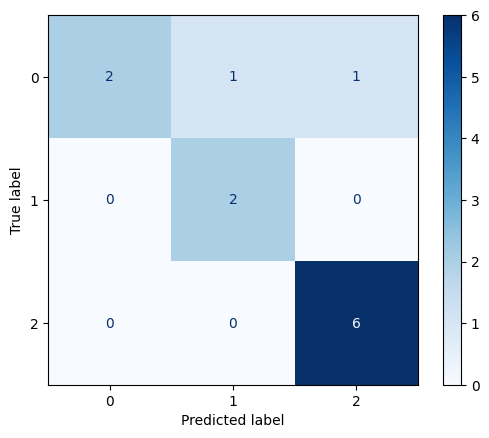


Classification Report:
               precision    recall  f1-score   support

     Class 0       1.00      0.50      0.67         4
     Class 1       0.67      1.00      0.80         2
     Class 2       0.86      1.00      0.92         6

    accuracy                           0.83        12
   macro avg       0.84      0.83      0.80        12
weighted avg       0.87      0.83      0.82        12



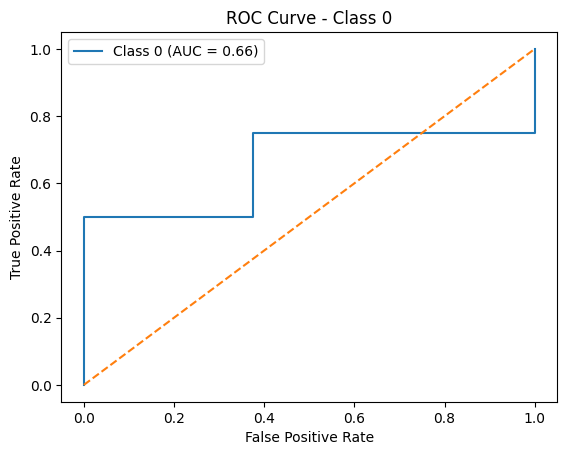

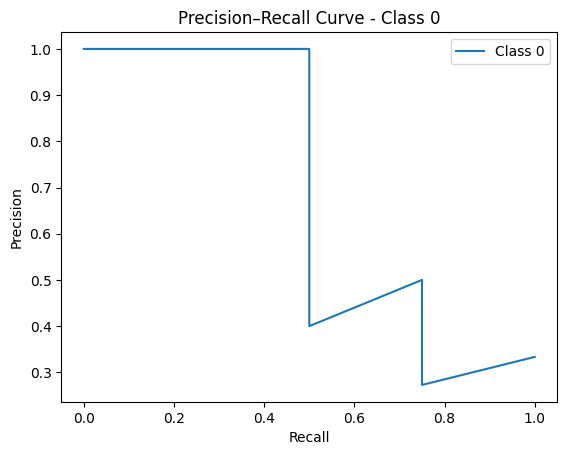

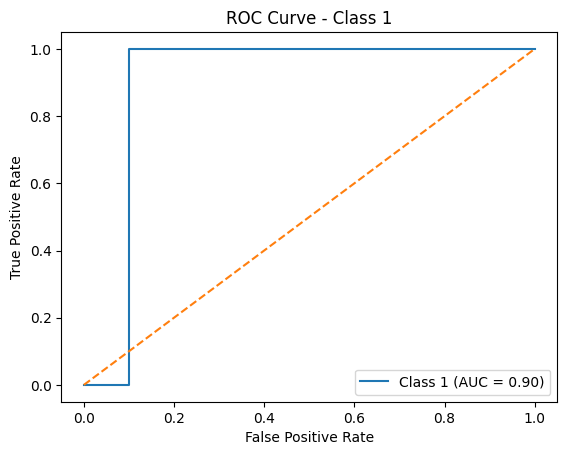

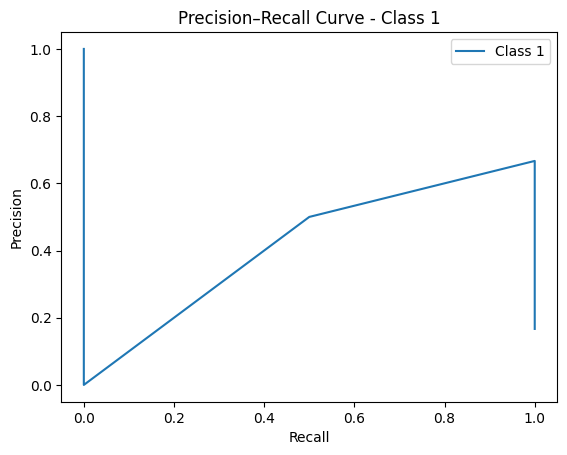

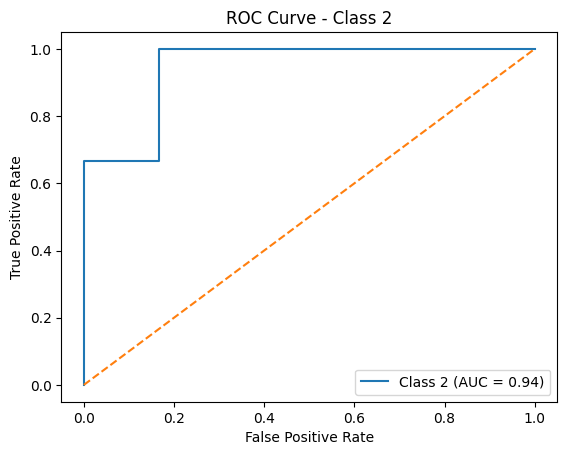

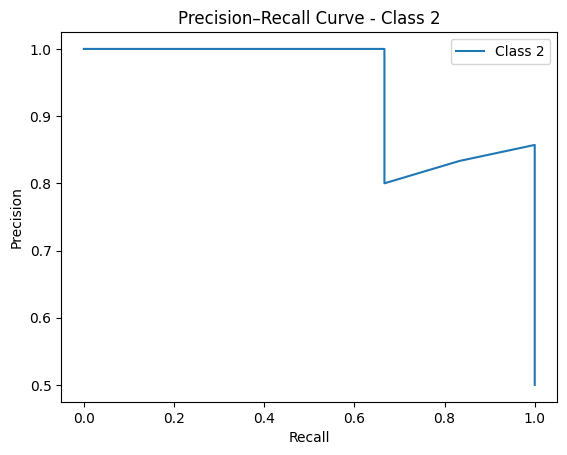

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.initializers import Constant
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt

# -------------------------------
# تعریف لایه سفارشی
class CustomRowPooling1D(layers.Layer):
    def __init__(self, pool_size=2, stride=None, **kwargs):
        super(CustomRowPooling1D, self).__init__(**kwargs)
        self.pool_size = pool_size
        self.stride = stride if stride else pool_size

    def call(self, inputs):
        batch_size, time_steps, features = inputs.shape
        outputs = []
        for i in range(0, time_steps - self.pool_size + 1, self.stride):
            window = inputs[:, i:i + self.pool_size, :]
            if window.shape[1] < 3:
                continue
            max_values = tf.reduce_max(
                [
                    window[:, -1, :] / (window[:, -2, :] + 1e-8),
                    window[:, -2, :] / (window[:, -3, :] + 1e-8)
                ],
                axis=0
            )
            outputs.append(max_values)
        if len(outputs) == 0:
            return inputs
        return tf.stack(outputs, axis=1)

    def compute_output_shape(self, input_shape):
        time_steps = input_shape[1]
        output_time_steps = max(1, (time_steps - self.pool_size + 1) // self.stride)
        return (input_shape[0], output_time_steps, input_shape[2])

    def get_config(self):
        config = super().get_config()
        config.update({"pool_size": self.pool_size, "stride": self.stride})
        return config

# -------------------------------
# داده ساختگی
num_classes = 3
samples_per_class = 20
matrix_size = (5, 15)

dataset = []
labels = []

for class_idx in range(num_classes):
    class_data = np.zeros((samples_per_class, matrix_size[0], matrix_size[1]))
    for sample_idx in range(samples_per_class):
        matrix = np.eye(matrix_size[0], matrix_size[1])
        for row in range(matrix_size[0]):
            matrix[row, 0] = np.random.rand()*10
            for col in range(1, matrix_size[1]):
                if class_idx == 0:
                    factor = 1 + np.random.rand()
                elif class_idx == 1:
                    factor = 3 + np.random.rand()
                elif class_idx == 2:
                    factor = 5 + np.random.rand()
                matrix[row, col] = matrix[row, col-1] * factor
                if matrix[row, col] > 4000:
                    matrix[row, col] = 4000
        class_data[sample_idx, :, :] = matrix
    dataset.append(class_data)
    labels += [class_idx] * samples_per_class

dataset = np.array(dataset).reshape(-1, matrix_size[0], matrix_size[1])
labels = np.array(labels)

dataset = dataset / (np.max(dataset) if np.max(dataset) > 0 else 1)

X_train, X_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.2, random_state=42)

y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)

# -------------------------------
# مدل پیشنهادی
model = models.Sequential([
    layers.Input(shape=(matrix_size[0], matrix_size[1])),
    CustomRowPooling1D(pool_size=3, stride=1),
    layers.Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPooling1D(pool_size=3),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# -------------------------------
# آموزش مدل
history = model.fit(
    X_train,
    y_train_cat,
    validation_split=0.2,
    epochs=70,
    batch_size=6,
    verbose=1
)

# -------------------------------
# ارزیابی کلی
test_loss, test_accuracy = model.evaluate(X_test, y_test_cat)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# -------------------------------
# نمودار دقت و خطا
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# -------------------------------
# پیش‌بینی و شاخص‌های اضافی
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = y_test

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:\n", cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Classification Report (Precision, Recall, F1)
report = classification_report(y_true, y_pred, target_names=[f'Class {i}' for i in range(num_classes)])
print("\nClassification Report:\n", report)

# -------------------------------
# ROC Curve و P–R Curve برای هر کلاس
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_test_cat[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.title(f'ROC Curve - Class {i}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

    precision, recall, _ = precision_recall_curve(y_test_cat[:, i], y_pred_probs[:, i])
    plt.figure()
    plt.plot(recall, precision, label=f'Class {i}')
    plt.title(f'Precision–Recall Curve - Class {i}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.show()
